## The Kalman Filter with control Inputs

The following is a specification of the Kalman Filter model with external "control" input $B u_t$:

$$
\begin{aligned}
\mathbf{x}_t &= \mathbf{A} \mathbf{x}_{t - 1} + \mathbf{B} \mathbf{u}_t +  \mathbf{q}_t,\\
\mathbf{y}_t &= \mathbf{H} \mathbf{x}_t + \mathbf{r}_t,
\end{aligned}
$$

where $q_t \sim N(\mathbf{0}, \mathbf{Q})$ and $\mathbf{r}_t \sim N(\mathbf{0}, \mathbf{R})$. The model matrices **A**, **B**, **H**, **Q**, and **R** may contain unknown parameters and are often specified to vary through time. The external "control-vector" input, $u_{t}$, must be known at all time points up to the present and, if the task requires predicting ahead multiple time steps, the future as well.

Contrast that with an ARMA model in state space representation (see the Example section in The Kalman Filter and (Maximum) Likelihood), where the internal system dynamics were the only forces at play. There is the advantage of ability predict arbitrarily long out into the future without needing values of future inputs, but the disadvantage of being a descriptive model only that has nothing to say about how certain inputs to the system affect it.

Presentations of the Kalman Filter that are of a statistical nature tend to zero the external control term out because this is good enough for a wide variety of descriptive time series models. This holds true for statisticial software as well, and we'll see the lack of a straightforward specification of the $B u_t$ component. Fortunately, statsmodels does offers an intercept to the state space model that can be specified uniquely at each time point, and this can be used to create the control scenario.

## Making statsmodels accept a control input
Take a moment to familiarize yourself with the [statsmodels statespace representation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.representation.Representation.html) which uses different notation for the state equation: $$ \alpha_t = T_t \alpha_{t-1} + c_t + R_t \eta_t$$.

Notice the  **state_intercept** $c_t$, which we have left at its default of zero. The description reads  "c : state_intercept (k_states x nobs)" meaning that the user is free to specify a different state intercept at every time point.  Since statsmodels allows all Kalman Filter model matrices (and vectors) to be different at ever time step, we can set $$ \mathbf{d}_t = \mathbf{B} \mathbf{u}_{t}, $$ for $t = 1 \ldots T$ and have a Kalman Filter model with control inputs.


# Example: the fitness-fatigue model in state space form

The fitness-fatigue model introduced in Modeling Cumulative Impact Part I has taken the form: 

$$
\text{E}(p_t) = 496 + 0.07 \sum_{i=1}^{t - 1} w_i \exp\left(\frac{-(t - i)}{\tau_1}\right) - 0.27 \sum_{i=1}^{t - 1} w_i \exp\left(\frac{-(t - i)}{\tau_2}\right),
$$
where $p_t$ is (athletic) performance and $w_t$ is training "dose" (typically time-weighted training intensity) at time $t$. Up until this point, convolutions of training history with impulse response functions as been the sole mechanism of representing the cumulative impact of the training sessions. In this article a second tool will be used: the system state. In order to do that, we must put the fitness-fatigue model in state-space form.

In the above equation, the first convolution sum represents atheletic fitness, which I'll now call $h_t$ and note that $h_{t - 1}$ is $$\sum_{i = 1}^{ t - \color{red}2} w_i \exp\left(\frac{-(t - i \color{red} - \color{red}1)}{\tau_1}\right).$$ 

Separating the last term from the sum in $h_t$, we arrive at the recursion:
$$
\begin{aligned}
h_t &= \sum_{i = 1}^{t - 2} w_i \exp\left(\frac{-(t - i)}{\tau_1}\right) + w_{t - 1} \exp\left(\frac{-1}{\tau_1}\right) \\
    &= e^{-1 / \tau_1} h_{t - 1} + e^{-1 / \tau_1} w_{t - 1}.
\end{aligned}
$$
This argument proceeds in the same manner for fatigue's convolution sum, now called $g_t$, the recursive relationship for both fitness and fatigue can be expressed in the following "state-space form":

$$\left(\begin{matrix} 
h_t \\
g_t
\end{matrix}\right)=\left(\begin{matrix} 
e^{-1 / \tau_1}& 0 \\
0 & e^{-1 / \tau_2}
\end{matrix}\right)
\left(\begin{matrix} 
h_{t - 1} \\
g_{t - 1}
\end{matrix}\right) +
\left(\begin{matrix} 
e^{-1 / \tau_1} \\
e^{-1 / \tau_2}
\end{matrix}\right) w_{t - 1}.
$$

We can continue using matrices to express the second stage of the model with:
$$
p_t = \mu + 
\left(\begin{matrix} 
k_1 & 0 \\
0 & k_2
\end{matrix}\right)
\left(\begin{matrix} 
h_t \\
g_t
\end{matrix}\right)
+ r_t,
$$
where $r_t \sim N(0, \sigma^2).$ We have now arrived at a state-space formulation of the fitness-fatigue model with exogenous control inputs. Combined with the measurement model of performance given the current state of fitness and fatigue, the Kalman Filter toolkit (state estimation, easy imputation, and likelihood evaluation) is now at our disposal.

There is a slight difference between this model and the one first presented, in that the control input is actually lagged by one time period. We'll have to account for this while specifying the model but it is otherwise not a problem.


The following is the code from  https://gist.github.com/baogorek/6d682e42079005b3bde951e98ebae89e. Need rpy2 for the load_ext to work.

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R -o train_df
train_df <- data.frame(day = 1:259, day_of_week = 0:258 %% 7)                
train_df$period <- ifelse(train_df$day <= 147, "build-up", "competition")       

train_df$w <- with(train_df, w <-                                               
  -24 * (day_of_week == 0) +                                                    
   12 * (day_of_week == 1) +                                                    
    8 * (day_of_week == 2) +                                                    
    0 * (day_of_week == 3) +                                                    
    6 * (day_of_week == 4) +                                                    
   -8 * (day_of_week == 5) +                                                    
    6 * (day_of_week == 6))                                                     

set.seed(1523)
train_df$w <- rpois(nrow(train_df),                                             
                    train_df$w + ifelse(train_df$period == "build-up", 34, 24)) 
                                                                                
exp_decay <- function(t, tau) {                                                 
  exp(-t / tau)                                                                 
}                                                                               
                                                                                
convolve_training <- function(training, n, tau) {                               
  sum(training[1:(n - 1)] * exp_decay((n - 1):1, tau))                          
}                                                                               
                                                                                
fitness <- sapply(1:nrow(train_df),                                             
                  function(n) convolve_training(train_df$w, n, 60))             
                                                                                
fatigue <- sapply(1:nrow(train_df),                                             
                  function(n) convolve_training(train_df$w, n, 13))             
                                                                                
E_perf <- 496 + .07 * fitness - .27 * fatigue
                  
set.seed(45345)                                                                         
train_df$perf <- E_perf + 7.0 * rnorm(nrow(train_df))


/home/baogorek/miniconda3/envs/tf/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [4]:
train_df.head()

,day,day_of_week,period,w,perf
0,1,0.0,build-up,10,489.197363
1,2,1.0,build-up,40,500.545312
2,3,2.0,build-up,42,479.886648
3,4,3.0,build-up,31,474.226865
4,5,4.0,build-up,46,459.322820


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel

train_df = pd.read_csv("/mnt/c/devl/data/train_df.csv")
#n = train_df.shape[0]
train_df.head()

,day,day_of_week,period,w,perf
0,1,0,build-up,10,489.197363
1,2,1,build-up,40,500.545312
2,3,2,build-up,42,479.886648
3,4,3,build-up,31,474.226865
4,5,4,build-up,46,459.322820


In [43]:
class FitnessFatigue(MLEModel):
    start_params = [20, 5, .05, -.15, 400, 35]
    param_names = ['tau_1', 'tau_2', 'k1', 'k2', 'int', 'sigma2_e']

    def __init__(self, endog, input_lag1):
        super().__init__(endog, k_states = 2)

        self.input_lag1 = input_lag1

        self.initialize_approximate_diffuse()
        self.loglikelihood_burn = 15
        #self.initialize_known(np.array([0, 0]), 2 * np.eye(2))

    def exp_decay(self, tau):
        return np.exp(-1.0 / tau)

    def update(self, params, **kwargs):

        params = super().update(params, **kwargs) # for param transformations

        # Preparing quantities
        decay_vec = np.reshape([self.exp_decay(params[0]),
                                self.exp_decay(params[1])], (2, 1))
        input_lag1_vecT = np.reshape(self.input_lag1, (1, -1))

        ## state part
        self['transition'] = np.diag(np.squeeze(decay_vec))
        self['state_intercept'] = np.matmul(decay_vec, input_lag1_vecT)

        ## measurement part
        self['design', 0, 0] = params[2]
        self['design', 0, 1] = params[3]

        ## observation part
        self['obs_intercept', 0, 0] = params[4]
        self['obs_cov', 0, 0] = params[5]


In [44]:
w_lag1 = train_df["w"].shift(periods = 1, fill_value = 0).values

my_FitnessFatigue = FitnessFatigue(train_df.perf.values, w_lag1)
mle_results = my_FitnessFatigue.fit(method = 'bfgs', maxiter = 1000)

mle_results.summary()

Optimization terminated successfully.
         Current function value: 3.190955
         Iterations: 115
         Function evaluations: 127
         Gradient evaluations: 127


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  259
Model:                 FitnessFatigue   Log Likelihood                -826.457
Date:                Mon, 17 Jun 2019   AIC                           1664.915
Time:                        09:44:26   BIC                           1685.898
Sample:                             0   HQIC                          1673.366
                                - 259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tau_1         52.0974     15.686      3.321      0.001      21.354      82.841
tau_2         16.2868      4.132      3.941      0.000       8.188      24.386
k1             0.0894      0.046      1.941      0.052      -0.001       0.180
k2            -0.2508      0.050     -5.018      0.000      -0.349      -0.153
int          498.8214     20.405     24.446      0.000     458.829     538.814
sigma2_e      50.5818      4.786     10.570      0.000      41.202      59.961
===================================================================================
Ljung-Box (Q):                       38.86   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.52   Prob(JB):                         0.83
Heteroskedasticity (H):               1.29   Skew:                             0.07
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

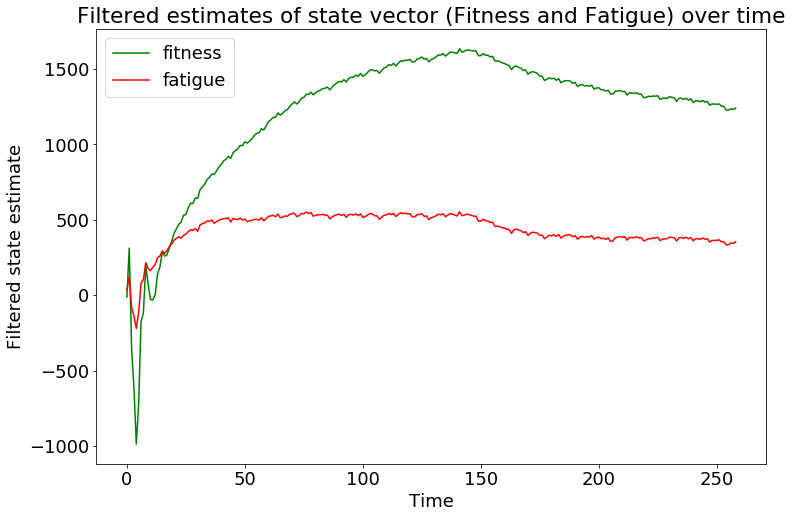

In [46]:
fig = plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 18})

plt.plot(mle_results.filtered_state[0, :], color='green', label='fitness')
plt.plot(mle_results.filtered_state[1, :], color='red', label='fatigue')
plt.title("Filtered estimates of state vector (Fitness and Fatigue) over time")
plt.xlabel('Time')
plt.ylabel('Filtered state estimate')
plt.legend()


plt.savefig('/mnt/c/devl/plots/state_est.png', dpi = fig.dpi)
plt.show()